In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [2]:
# -----------------------------
# 학습 데이터 로딩 및 전처리
# -----------------------------
call_df = pd.read_csv("call119_train.csv", index_col=0)

# 컬럼명 통일
call_df = call_df.rename(columns={
    'call119_train.tm': 'tm',
    'call119_train.address_city': 'city',
    'call119_train.address_gu': 'gu',
    'call119_train.sub_address': 'dong',
    'call119_train.stn': 'stn',
    'call119_train.ta_max': 'ta_max',
    'call119_train.ta_min': 'ta_min',
    'call119_train.ta_max_min': 'ta_max_min',
    'call119_train.hm_min': 'hm_min',
    'call119_train.hm_max': 'hm_max',
    'call119_train.ws_max': 'ws_max',
    'call119_train.ws_ins_max': 'ws_ins_max',
    'call119_train.rn_day': 'rn_day',
    'call119_train.call_count': 'call_total'
})

# 숫자형 처리 및 파일내 결측치(-99)를 nan으로 변환
num_cols = ['ta_max', 'ta_min', 'ta_max_min', 'hm_min', 'hm_max', 'ws_max', 'ws_ins_max', 'rn_day']
for col in num_cols:
    call_df[col] = pd.to_numeric(call_df[col], errors='coerce')
    call_df[col] = call_df[col].replace(-99.0, np.nan)

In [3]:
# 필요없는 칼럼 제거 (stn은 보류)
call_df = call_df.drop(columns=['tm', 'city', 'dong'])

In [4]:
# 각 칼럼별 최소값, 최대값, 결측치 갯수, 총 갯수, 결측치가 전체의 몇퍼센트인지 출력
def print_column_info(df):
    for col in df.columns:
        min_val = df[col].min()
        max_val = df[col].max()
        missing_count = df[col].isnull().sum()
        total_count = len(df[col])
        missing_percentage = (missing_count / total_count) * 100
        print(f"{col}: min={min_val}, max={max_val}, missing={missing_count}, total={total_count}, missing_percentage={missing_percentage:.2f}%")

print_column_info(call_df)

gu: min=강서구, max=해운대구, missing=0, total=42924, missing_percentage=0.00%
stn: min=159, max=950, missing=0, total=42924, missing_percentage=0.00%
ta_max: min=12.3, max=37.6, missing=133, total=42924, missing_percentage=0.31%
ta_min: min=2.7, max=29.0, missing=133, total=42924, missing_percentage=0.31%
ta_max_min: min=0.0, max=23.0, missing=133, total=42924, missing_percentage=0.31%
hm_min: min=2.3, max=99.5, missing=3056, total=42924, missing_percentage=7.12%
hm_max: min=39.5, max=100.0, missing=3056, total=42924, missing_percentage=7.12%
ws_max: min=1.2, max=30.7, missing=141, total=42924, missing_percentage=0.33%
ws_ins_max: min=2.4, max=37.8, missing=141, total=42924, missing_percentage=0.33%
rn_day: min=0.0, max=259.2, missing=255, total=42924, missing_percentage=0.59%
call_total: min=1, max=115, missing=0, total=42924, missing_percentage=0.00%


In [5]:
# 결측 제거
call_df = call_df.dropna(subset=num_cols + ['call_total'])

print_column_info(call_df)

gu: min=강서구, max=해운대구, missing=0, total=39737, missing_percentage=0.00%
stn: min=159, max=950, missing=0, total=39737, missing_percentage=0.00%
ta_max: min=12.3, max=37.2, missing=0, total=39737, missing_percentage=0.00%
ta_min: min=2.7, max=29.0, missing=0, total=39737, missing_percentage=0.00%
ta_max_min: min=0.6, max=23.0, missing=0, total=39737, missing_percentage=0.00%
hm_min: min=2.3, max=99.5, missing=0, total=39737, missing_percentage=0.00%
hm_max: min=39.5, max=100.0, missing=0, total=39737, missing_percentage=0.00%
ws_max: min=1.2, max=30.7, missing=0, total=39737, missing_percentage=0.00%
ws_ins_max: min=2.4, max=37.8, missing=0, total=39737, missing_percentage=0.00%
rn_day: min=0.0, max=259.2, missing=0, total=39737, missing_percentage=0.00%
call_total: min=1, max=74, missing=0, total=39737, missing_percentage=0.00%


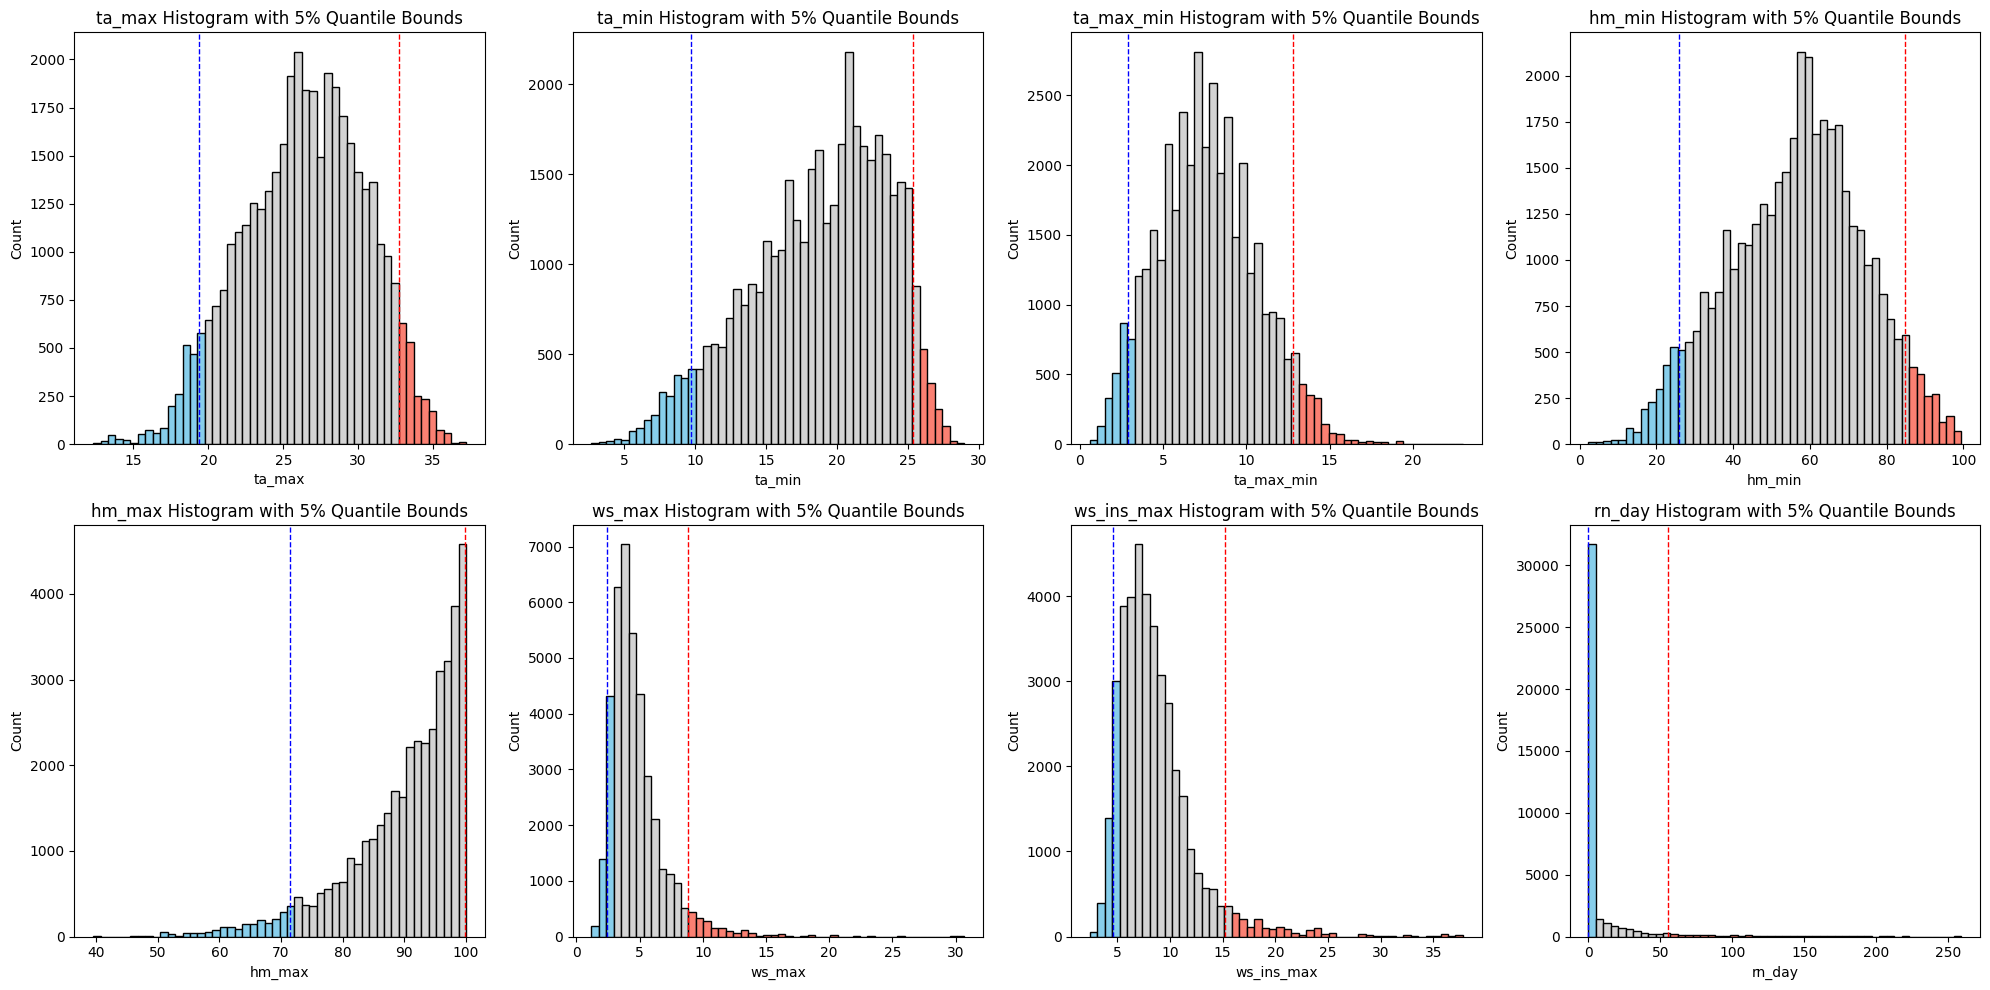

In [6]:
# 칼럼별 이상치 시각화 (한줄에 4개씩 3행, 선그래프로 시각화)
import matplotlib.pyplot as plt
import numpy as np

def plot_hist_with_outlier_bounds(df, lower_pct=0.05, upper_pct=0.95):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    # 제외할 칼럼
    exclude_cols = ['stn', 'call_total']
    num_cols = [col for col in num_cols if col not in exclude_cols]
    
    n_cols = 4
    n_rows = (len(num_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(20, 5 * n_rows))
    for i, col in enumerate(num_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        
        data = df[col].dropna()
        lower_bound = data.quantile(lower_pct)
        upper_bound = data.quantile(upper_pct)
        
        counts, bins, patches = plt.hist(data, bins=50, color='lightgray', edgecolor='black')
        
        # 하위 5% 구간 색칠
        for patch, bin_left in zip(patches, bins):
            if bin_left <= lower_bound:
                patch.set_facecolor('skyblue')
        
        # 상위 5% 구간 색칠
        for patch, bin_left in zip(patches, bins):
            if bin_left >= upper_bound:
                patch.set_facecolor('salmon')
        
        plt.axvline(lower_bound, color='blue', linestyle='dashed', linewidth=1)
        plt.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1)
        
        plt.title(f"{col} Histogram with 5% Quantile Bounds")
        plt.xlabel(col)
        plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_hist_with_outlier_bounds(call_df)

In [7]:
# 각 칼럼별 상위 5%의 이상치의 수치가 평균보다 얼마나 높은지 확인
def print_outlier_stats(df, lower_pct=0.05, upper_pct=0.95):
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    exclude_cols = ['stn', 'call_total']
    num_cols = [col for col in num_cols if col not in exclude_cols]
    
    for col in num_cols:
        data = df[col].dropna()
        lower_bound = data.quantile(lower_pct)
        upper_bound = data.quantile(upper_pct)
        mean_val = data.mean()
        
        outliers_above_mean = data[data > mean_val]
        outlier_count = outliers_above_mean.count()
        
        print(f"{col}: Lower Bound={lower_bound}, Upper Bound={upper_bound}, Mean={mean_val}, Outliers Above Mean Count={outlier_count}")

print_outlier_stats(call_df)

ta_max: Lower Bound=19.4, Upper Bound=32.7, Mean=26.43991997382792, Outliers Above Mean Count=20395
ta_min: Lower Bound=9.7, Upper Bound=25.4, Mean=18.788474217983243, Outliers Above Mean Count=21829
ta_max_min: Lower Bound=2.9, Upper Bound=12.8, Mean=7.651445755844679, Outliers Above Mean Count=19168
hm_min: Lower Bound=25.8, Upper Bound=84.8, Mean=56.63928077106977, Outliers Above Mean Count=21226
hm_max: Lower Bound=71.5, Upper Bound=99.9, Mean=90.03973878249491, Outliers Above Mean Count=24280
ws_max: Lower Bound=2.4, Upper Bound=8.8, Mean=4.751166419206281, Outliers Above Mean Count=15088
ws_ins_max: Lower Bound=4.6, Upper Bound=15.2, Mean=8.552681380073986, Outliers Above Mean Count=15646
rn_day: Lower Bound=0.0, Upper Bound=55.0, Mean=8.698306364345571, Outliers Above Mean Count=7033
